In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [5]:
# Get data
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
print("train : " + str(train.shape))
print("test : " + str(test.shape))

train : (1460, 81)
test : (1459, 80)


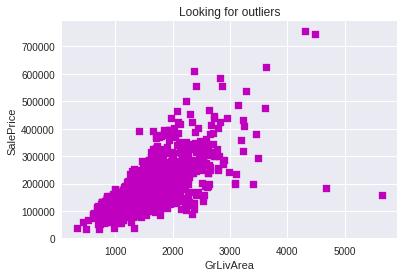

In [6]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "m", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

In [7]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice
#train.drop(['SalePrice'])

In [8]:
combine = [train, test]

In [9]:
# Handle missing values for features where median/mean or most common value doesn't make sense

for dataset in combine:
    # Alley : data description says NA means "no alley access"
    dataset.loc[:, "Alley"] = dataset.loc[:, "Alley"].fillna("None")
    # BedroomAbvGr : NA most likely means 0
    dataset.loc[:, "BedroomAbvGr"] = dataset.loc[:, "BedroomAbvGr"].fillna(0)
    # BsmtQual etc : data description says NA for basement features is "no basement"
    dataset.loc[:, "BsmtQual"] = dataset.loc[:, "BsmtQual"].fillna("No")
    dataset.loc[:, "BsmtCond"] = dataset.loc[:, "BsmtCond"].fillna("No")
    dataset.loc[:, "BsmtExposure"] = dataset.loc[:, "BsmtExposure"].fillna("No")
    dataset.loc[:, "BsmtFinType1"] = dataset.loc[:, "BsmtFinType1"].fillna("No")
    dataset.loc[:, "BsmtFinType2"] = dataset.loc[:, "BsmtFinType2"].fillna("No")
    dataset.loc[:, "BsmtFullBath"] = dataset.loc[:, "BsmtFullBath"].fillna(0)
    dataset.loc[:, "BsmtHalfBath"] = dataset.loc[:, "BsmtHalfBath"].fillna(0)
    dataset.loc[:, "BsmtUnfSF"] = dataset.loc[:, "BsmtUnfSF"].fillna(0)
    # CentralAir : NA most likely means No
    dataset.loc[:, "CentralAir"] = dataset.loc[:, "CentralAir"].fillna("N")
    # Condition : NA most likely means Normal
    dataset.loc[:, "Condition1"] = dataset.loc[:, "Condition1"].fillna("Norm")
    dataset.loc[:, "Condition2"] = dataset.loc[:, "Condition2"].fillna("Norm")
    # EnclosedPorch : NA most likely means no enclosed porch
    dataset.loc[:, "EnclosedPorch"] = dataset.loc[:, "EnclosedPorch"].fillna(0)
    # External stuff : NA most likely means average
    dataset.loc[:, "ExterCond"] = dataset.loc[:, "ExterCond"].fillna("TA")
    dataset.loc[:, "ExterQual"] = dataset.loc[:, "ExterQual"].fillna("TA")
    # Fence : data description says NA means "no fence"
    dataset.loc[:, "Fence"] = dataset.loc[:, "Fence"].fillna("No")
    # FireplaceQu : data description says NA means "no fireplace"
    dataset.loc[:, "FireplaceQu"] = dataset.loc[:, "FireplaceQu"].fillna("No")
    dataset.loc[:, "Fireplaces"] = dataset.loc[:, "Fireplaces"].fillna(0)
    # Functional : data description says NA means typical
    dataset.loc[:, "Functional"] = dataset.loc[:, "Functional"].fillna("Typ")
    # GarageType etc : data description says NA for garage features is "no garage"
    dataset.loc[:, "GarageType"] = dataset.loc[:, "GarageType"].fillna("No")
    dataset.loc[:, "GarageFinish"] = dataset.loc[:, "GarageFinish"].fillna("No")
    dataset.loc[:, "GarageQual"] = dataset.loc[:, "GarageQual"].fillna("No")
    dataset.loc[:, "GarageCond"] = dataset.loc[:, "GarageCond"].fillna("No")
    dataset.loc[:, "GarageArea"] = dataset.loc[:, "GarageArea"].fillna(0)
    dataset.loc[:, "GarageCars"] = dataset.loc[:, "GarageCars"].fillna(0)
    # HalfBath : NA most likely means no half baths above grade
    dataset.loc[:, "HalfBath"] = dataset.loc[:, "HalfBath"].fillna(0)
    # HeatingQC : NA most likely means typical
    dataset.loc[:, "HeatingQC"] = dataset.loc[:, "HeatingQC"].fillna("TA")
    # KitchenAbvGr : NA most likely means 0
    dataset.loc[:, "KitchenAbvGr"] = dataset.loc[:, "KitchenAbvGr"].fillna(0)
    # KitchenQual : NA most likely means typical
    dataset.loc[:, "KitchenQual"] = dataset.loc[:, "KitchenQual"].fillna("TA")
    # LotFrontage : NA most likely means no lot frontage
    dataset.loc[:, "LotFrontage"] = dataset.loc[:, "LotFrontage"].fillna(0)
    # LotShape : NA most likely means regular
    dataset.loc[:, "LotShape"] = dataset.loc[:, "LotShape"].fillna("Reg")
    # MasVnrType : NA most likely means no veneer
    dataset.loc[:, "MasVnrType"] = dataset.loc[:, "MasVnrType"].fillna("None")
    dataset.loc[:, "MasVnrArea"] = dataset.loc[:, "MasVnrArea"].fillna(0)
    # MiscFeature : data description says NA means "no misc feature"
    dataset.loc[:, "MiscFeature"] = dataset.loc[:, "MiscFeature"].fillna("No")
    dataset.loc[:, "MiscVal"] = dataset.loc[:, "MiscVal"].fillna(0)
    # OpenPorchSF : NA most likely means no open porch
    dataset.loc[:, "OpenPorchSF"] = dataset.loc[:, "OpenPorchSF"].fillna(0)
    # PavedDrive : NA most likely means not paved
    dataset.loc[:, "PavedDrive"] = dataset.loc[:, "PavedDrive"].fillna("N")
    # PoolQC : data description says NA means "no pool"
    dataset.loc[:, "PoolQC"] = dataset.loc[:, "PoolQC"].fillna("No")
    dataset.loc[:, "PoolArea"] = dataset.loc[:, "PoolArea"].fillna(0)
    # SaleCondition : NA most likely means normal sale
    dataset.loc[:, "SaleCondition"] = dataset.loc[:, "SaleCondition"].fillna("Normal")
    # ScreenPorch : NA most likely means no screen porch
    dataset.loc[:, "ScreenPorch"] = dataset.loc[:, "ScreenPorch"].fillna(0)
    # TotRmsAbvGrd : NA most likely means 0
    dataset.loc[:, "TotRmsAbvGrd"] = dataset.loc[:, "TotRmsAbvGrd"].fillna(0)
    # Utilities : NA most likely means all public utilities
    dataset.loc[:, "Utilities"] = dataset.loc[:, "Utilities"].fillna("AllPub")
    # WoodDeckSF : NA most likely means no wood deck
    dataset.loc[:, "WoodDeckSF"] = dataset.loc[:, "WoodDeckSF"].fillna(0)
    # Electrical : NA most likely means 

In [11]:
#finding out the features with missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(11) #11 features with missing data, some of them are categorical features and can be deleted

,Total,Percent
GarageYrBlt,81,0.056
Electrical,1,0.001
SalePrice,0,0.000
ExterCond,0,0.000
RoofStyle,0,0.000
RoofMatl,0,0.000
Exterior1st,0,0.000
Exterior2nd,0,0.000
MasVnrType,0,0.000
MasVnrArea,0,0.000


In [12]:
#finding out the features with missing data
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(11) #11 features with missing data, some of them are categorical features and can be deleted

,Total,Percent
GarageYrBlt,78,0.053
MSZoning,4,0.003
TotalBsmtSF,1,0.001
BsmtFinSF2,1,0.001
BsmtFinSF1,1,0.001
Exterior2nd,1,0.001
Exterior1st,1,0.001
SaleType,1,0.001
LotShape,0,0.000
Street,0,0.000


In [13]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}})

In [33]:
# Some numerical features are actually really categories
test = test.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}})

In [15]:
# Encode some categorical features as ordered numbers when there is information in the order

train = train.replace({"Alley" : {"None": 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}})

test = test.replace({"Alley" : {"None": 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}})

In [ ]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                                     3 : 2, 4 : 2 # good
                                                   })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                             2 : 2, 3 : 2, # average
                                                             4 : 3, 5 : 3 # good
                                                           })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                             2 : 2, 3 : 2, # average
                                                             4 : 3, 5 : 3 # good
                                                           })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                          })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                          })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                         3 : 2, 4 : 2, # major
                                                         5 : 3, 6 : 3, 7 : 3, # minor
                                                         8 : 4 # typical
                                                        })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                          })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                      })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                             2 : 2, 3 : 2, # rec room
                                                             4 : 3, 5 : 3, 6 : 3 # living quarters
                                                            })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                             2 : 2, 3 : 2, # rec room
                                                             4 : 3, 5 : 3, 6 : 3 # living quarters
                                                            })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                    })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                    })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                      })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                      })




test["SimplOverallQual"] = test.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
test["SimplOverallCond"] = test.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
test["SimplPoolQC"] = test.PoolQC.replace({1 : 1, 2 : 1, # average
                                                     3 : 2, 4 : 2 # good
                                                   })
test["SimplGarageCond"] = test.GarageCond.replace({1 : 1, # bad
                                                             2 : 2, 3 : 2, # average
                                                             4 : 3, 5 : 3 # good
                                                           })
test["SimplGarageQual"] = test.GarageQual.replace({1 : 1, # bad
                                                             2 : 2, 3 : 2, # average
                                                             4 : 3, 5 : 3 # good
                                                           })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                          })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                          })
test["SimplFunctional"] = test.Functional.replace({1 : 1, 2 : 1, # bad
                                                         3 : 2, 4 : 2, # major
                                                         5 : 3, 6 : 3, 7 : 3, # minor
                                                         8 : 4 # typical
                                                        })
test["SimplKitchenQual"] = test.KitchenQual.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                          })
test["SimplHeatingQC"] = test.HeatingQC.replace({1 : 1, # bad
                                                         2 : 2, 3 : 2, # average
                                                         4 : 3, 5 : 3 # good
                                                      })
test["SimplBsmtFinType1"] = test.BsmtFinType1.replace({1 : 1, # unfinished
                                                             2 : 2, 3 : 2, # rec room
                                                             4 : 3, 5 : 3, 6 : 3 # living quarters
                                                            })
test["SimplBsmtFinType2"] = test.BsmtFinType2.replace({1 : 1, # unfinished
                                                             2 : 2, 3 : 2, # rec room
                                                             4 : 3, 5 : 3, 6 : 3 # living quarters
                                                            })
test["SimplBsmtCond"] = test.BsmtCond.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                    })
test["SimplBsmtQual"] = test.BsmtQual.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                    })
test["SimplExterCond"] = test.ExterCond.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                      })
test["SimplExterQual"] = test.ExterQual.replace({1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                      })

In [16]:
combine = [train, test]
for dataset in combine:
    # 2* Combinations of existing features
    # Overall quality of the house
    dataset["OverallGrade"] = dataset["OverallQual"] * dataset["OverallCond"]
    # Overall quality of the garage
    dataset["GarageGrade"] = dataset["GarageQual"] * dataset["GarageCond"]
    # Overall quality of the exterior
    dataset["ExterGrade"] = dataset["ExterQual"] * dataset["ExterCond"]
    # Overall kitchen score
    dataset["KitchenScore"] = dataset["KitchenAbvGr"] * dataset["KitchenQual"]
    # Overall fireplace score
    dataset["FireplaceScore"] = dataset["Fireplaces"] * dataset["FireplaceQu"]
    # Overall garage score
    dataset["GarageScore"] = dataset["GarageArea"] * dataset["GarageQual"]
    # Overall pool score
    dataset["PoolScore"] = dataset["PoolArea"] * dataset["PoolQC"]
    # Simplified overall quality of the house
    # dataset["SimplOverallGrade"] = dataset["SimplOverallQual"] * dataset["SimplOverallCond"]
    # Simplified overall quality of the exterior
    # dataset["SimplExterGrade"] = dataset["SimplExterQual"] * dataset["SimplExterCond"]
    # Simplified overall pool score
    # dataset["SimplPoolScore"] = dataset["PoolArea"] * dataset["SimplPoolQC"]
    # Simplified overall garage score
    # dataset["SimplGarageScore"] = dataset["GarageArea"] * dataset["SimplGarageQual"]
    # Simplified overall fireplace score
    #vdataset["SimplFireplaceScore"] = dataset["Fireplaces"] * dataset["SimplFireplaceQu"]
    # Simplified overall kitchen score
    # dataset["SimplKitchenScore"] = dataset["KitchenAbvGr"] * dataset["SimplKitchenQual"]
    
    # Total number of bathrooms
    dataset["TotalBath"] = dataset["BsmtFullBath"] + (0.5 * dataset["BsmtHalfBath"]) + dataset["FullBath"] + (0.5 * dataset["HalfBath"])
    # Total SF for house (incl. basement)
    dataset["AllSF"] = dataset["GrLivArea"] + dataset["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    dataset["AllFlrsSF"] = dataset["1stFlrSF"] + dataset["2ndFlrSF"]
    # Total SF for porch
    dataset["AllPorchSF"] = dataset["OpenPorchSF"] + dataset["EnclosedPorch"] + dataset["3SsnPorch"] + dataset["ScreenPorch"]

In [17]:
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})
test["HasMasVnr"] = test.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})

# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})
test["BoughtOffPlan"] = test.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})

In [37]:
# House completed before sale or not
train["CentralAir"] = train.CentralAir.replace({"N" : 0, "Y" : 1})
test["CentralAir"] = test.CentralAir.replace({"N" : 0, "Y" : 1})

In [18]:
combine = [train, test]

In [19]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice         1.000
OverallQual       0.819
AllSF             0.817
AllFlrsSF         0.729
GrLivArea         0.719
ExterQual         0.681
GarageCars        0.680
TotalBath         0.673
KitchenQual       0.667
GarageScore       0.657
GarageArea        0.655
TotalBsmtSF       0.642
BsmtQual          0.615
1stFlrSF          0.614
OverallGrade      0.604
FullBath          0.591
YearBuilt         0.589
ExterGrade        0.587
YearRemodAdd      0.569
FireplaceQu       0.547
GarageYrBlt       0.544
TotRmsAbvGrd      0.533
FireplaceScore    0.518
Fireplaces        0.487
HeatingQC         0.474
MasVnrArea        0.426
KitchenScore      0.402
HasMasVnr         0.391
BsmtFinSF1        0.383
GarageGrade       0.366
                  ...  
PavedDrive        0.306
BsmtCond          0.277
LotArea           0.259
BsmtFullBath      0.239
BsmtUnfSF         0.223
BedroomAbvGr      0.204
AllPorchSF        0.199
LotFrontage       0.174
Functional      

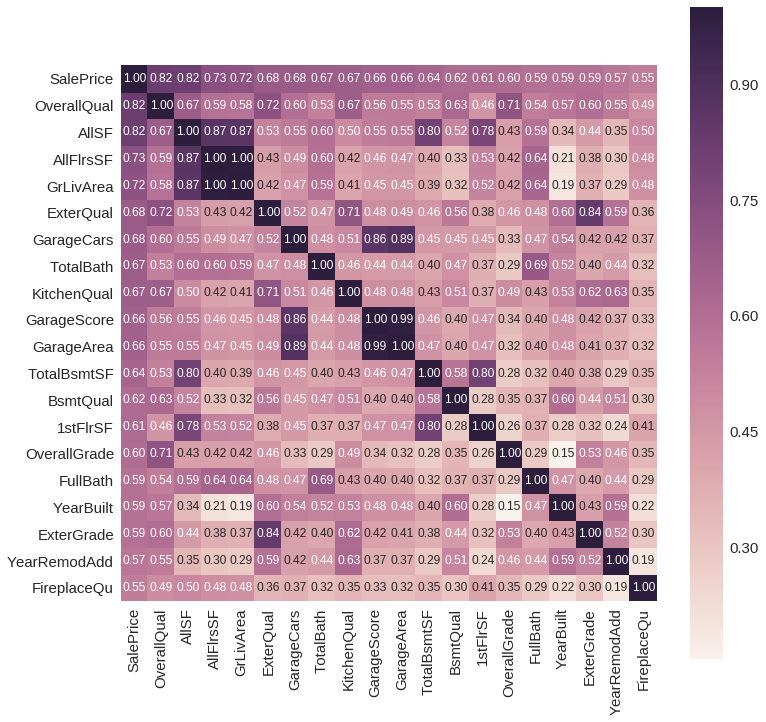

In [25]:
k = 20 #number of variables for the heatmap
cols = corr.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
plt.subplots(figsize=(12,12))
sns.set(font_scale=1.5)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':12}, yticklabels=cols.values, xticklabels=cols.values)

In [26]:
for dataset in combine:
    # Create new features
    # 3* Polynomials on the top 10 existing features
    dataset["OverallQual-s2"] = dataset["OverallQual"] ** 2
    dataset["OverallQual-s3"] = dataset["OverallQual"] ** 3
    dataset["OverallQual-Sq"] = np.sqrt(dataset["OverallQual"])

    dataset["AllSF-2"] = dataset["AllSF"] ** 2
    dataset["AllSF-3"] = dataset["AllSF"] ** 3
    dataset["AllSF-Sq"] = np.sqrt(dataset["AllSF"])

    dataset["AllFlrsSF-2"] = dataset["AllFlrsSF"] ** 2
    dataset["AllFlrsSF-3"] = dataset["AllFlrsSF"] ** 3
    dataset["AllFlrsSF-Sq"] = np.sqrt(dataset["AllFlrsSF"])

    # dataset["GrLivArea-2"] = dataset["GrLivArea"] ** 2
    # dataset["GrLivArea-3"] = dataset["GrLivArea"] ** 3
    # dataset["GrLivArea-Sq"] = np.sqrt(dataset["GrLivArea"])

    dataset["ExterQual-2"] = dataset["ExterQual"] ** 2
    dataset["ExterQual-3"] = dataset["ExterQual"] ** 3
    dataset["ExterQual-Sq"] = np.sqrt(dataset["ExterQual"])

    dataset["GarageCars-2"] = dataset["GarageCars"] ** 2
    dataset["GarageCars-3"] = dataset["GarageCars"] ** 3
    dataset["GarageCars-Sq"] = np.sqrt(dataset["GarageCars"])

    dataset["TotalBath-2"] = dataset["TotalBath"] ** 2
    dataset["TotalBath-3"] = dataset["TotalBath"] ** 3
    dataset["TotalBath-Sq"] = np.sqrt(dataset["TotalBath"])

    dataset["KitchenQual-2"] = dataset["KitchenQual"] ** 2
    dataset["KitchenQual-3"] = dataset["KitchenQual"] ** 3
    dataset["KitchenQual-Sq"] = np.sqrt(dataset["KitchenQual"])

    dataset["GarageScore-2"] = dataset["GarageScore"] ** 2
    dataset["GarageScore-3"] = dataset["GarageScore"] ** 3
    dataset["GarageScore-Sq"] = np.sqrt(dataset["GarageScore"])

    dataset["TotalBsmtSF-2"] = dataset["TotalBsmtSF"] ** 2
    dataset["TotalBsmtSF-3"] = dataset["TotalBsmtSF"] ** 3
    dataset["TotalBsmtSF-Sq"] = np.sqrt(dataset["TotalBsmtSF"])
    
    dataset["BsmtQual-2"] = dataset["BsmtQual"] ** 2
    dataset["BsmtQual-3"] = dataset["BsmtQual"] ** 3
    dataset["BsmtQual-Sq"] = np.sqrt(dataset["BsmtQual"])

In [38]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 99
Categorical features : 24


In [35]:
print(train.select_dtypes(include=['object']).columns.values)
print('\n')
print(test.select_dtypes(include=['object']).columns.values)

['MSSubClass' 'MSZoning' 'LandContour' 'LotConfig' 'Neighborhood'
 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl'
 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'Foundation' 'Heating'
 'CentralAir' 'Electrical' 'GarageType' 'GarageFinish' 'Fence'
 'MiscFeature' 'MoSold' 'SaleType' 'SaleCondition']


['MSSubClass' 'MSZoning' 'LandContour' 'LotConfig' 'Neighborhood'
 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl'
 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'Foundation' 'Heating'
 'CentralAir' 'Electrical' 'GarageType' 'GarageFinish' 'Fence'
 'MiscFeature' 'MoSold' 'SaleType' 'SaleCondition']


In [39]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = test.select_dtypes(include = ["object"]).columns
numerical_features = test.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
test_num = test[numerical_features]
test_cat = test[categorical_features]

Numerical features : 99
Categorical features : 24


In [40]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [41]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(test_num.isnull().values.sum()))
test_num = test_num.fillna(test_num.median())
print("Remaining NAs for numerical features in train : " + str(test_num.isnull().values.sum()))

NAs for numerical features in train : 88
Remaining NAs for numerical features in train : 0


In [42]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

76 skewed numerical features to log transform


In [43]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = test_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
test_num[skewed_features] = np.log1p(test_num[skewed_features])

76 skewed numerical features to log transform


In [44]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


In [45]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(test_cat.isnull().values.sum()))
test_cat = pd.get_dummies(test_cat)
print("Remaining NAs for categorical features in train : " + str(test_cat.isnull().values.sum()))

NAs for categorical features in train : 7
Remaining NAs for categorical features in train : 0


In [49]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.3, random_state=0)

test = pd.concat([test_num, test_cat], axis = 1)
X_test = test
print("X_train : " + str(X_train.shape))
print("X_val : " + str(X_val.shape))
print("y_train : " + str(y_train.shape))
print("y_val : " + str(y_val.shape))
print("X_test : " + str(X_test.shape))

New number of features : 296
X_train : (1019, 296)
X_val : (437, 296)
y_train : (1019,)
y_val : (437,)
X_test : (1459, 283)


In [50]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_val.loc[:, numerical_features] = stdSc.fit_transform(X_val.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [55]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_val, y_val, scoring = scorer, cv = 10))
    return(rmse)

('RMSE on Training set :', 0.2058318149779336)
('RMSE on Test set :', 0.37077791637937063)


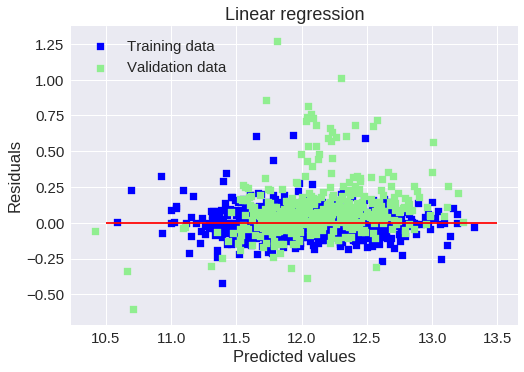

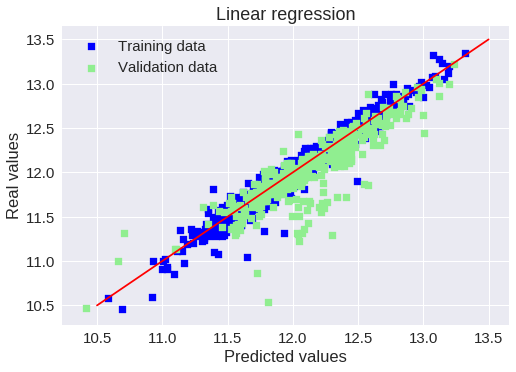

In [56]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_pred, y_val_pred - y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_pred, y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

('Best alpha :', 30.0)
Try again for more precision with alphas centered around 30.0
('Best alpha :', 21.0)
('Ridge RMSE on Training set :', 0.11445566279736248)
('Ridge RMSE on Test set :', 0.11348124456932243)


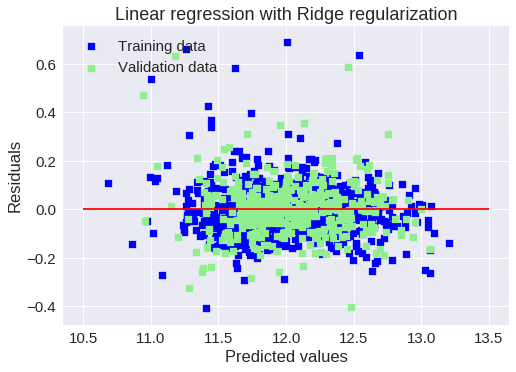

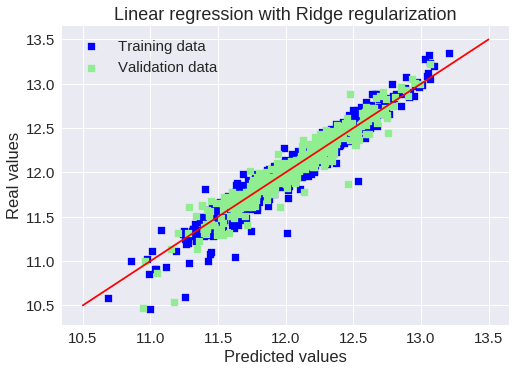

Ridge picked 293 features and eliminated the other 3 features


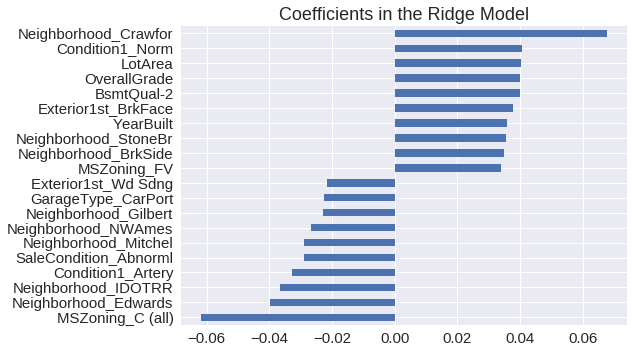

In [57]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_val_rdg = ridge.predict(X_val)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_rdg, y_val_rdg - y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_rdg, y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [ ]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [ ]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()